In [206]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import joblib
import seaborn as sns

In [207]:
df = pd.read_csv('data.csv')

In [208]:
# Función personalizada para arreglar el formato de tiempo sucio
def extraer_horas(valor):
    try:
        valor_str = str(valor)
        # Tomamos lo que está después del punto final (ej: "000000008")
        # y lo convertimos a float (8.0)
        horas = float(valor_str.split('.')[-1])
        return horas
    except:
        return np.nan

In [209]:
# Aplicamos la limpieza a la columna target
df['tiempo_real'] = df['delivery_time_hours'].apply(extraer_horas)

In [210]:
# Variables Numéricas (Física del problema)
#No se consideran varibnles como 'delivery_rating', 'delivery_cost' porque no aportan al tiempo de entrega
features_num = ['distance_km', 'package_weight_kg']

# Variables Categóricas (Contexto)
# delivery_partner y region suelen tener muchas categorias, las incluimos
features_cat = ['delivery_partner', 'package_type', 'vehicle_type', 'delivery_mode', 'weather_condition']

# Definimos X (Entrada) e y (Salida)
X = df[features_num + features_cat]
y = df['tiempo_real']

In [211]:
X.head()

,distance_km,package_weight_kg,delivery_partner,package_type,vehicle_type,delivery_mode,weather_condition
0,297.0,46.96,delhivery,automobile parts,bike,same day,clear
1,89.6,47.39,xpressbees,cosmetics,ev van,express,cold
2,273.5,26.89,shadowfax,groceries,truck,two day,rainy
3,269.7,12.69,dhl,electronics,ev van,same day,cold
4,256.7,37.02,dhl,clothing,van,two day,foggy


In [212]:
y.head()

0     8.0
1     2.0
2    10.0
3     6.0
4     9.0
Name: tiempo_real, dtype: float64

In [213]:
# Definimos X (Entrada) e y (Salida)
X = df[features_num + features_cat]
y = df['tiempo_real']

In [214]:
# 1. Primero separamos el Test Final (15%) del resto (85%)
X_main, X_test, y_main, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# 2. Ahora separamos el Validation (15% del total original aprox) del Train
# Como X_main es el 85% del total, sacar el 17.6% de eso nos da ~15% del total original.
# O simplificamos: Train 70%, Val 15%, Test 15%
X_train, X_val, y_train, y_val = train_test_split(X_main, y_main, test_size=0.1765, random_state=42)

In [215]:
# Transformador: Escala números y convierte texto a binario
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features_num),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), features_cat)
    ])

In [216]:
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc   = preprocessor.transform(X_val)   
X_test_proc  = preprocessor.transform(X_test)

Primer modelo

In [217]:
X_train_proc.shape

(17499, 36)

In [218]:
model = keras.Sequential([
    # Capa de entrada dinámica según las columnas procesadas
    keras.layers.Input(shape=(X_train_proc.shape[1],)),
    
    # Capas Ocultas (Arquitectura Base)
    keras.layers.Dense(64, activation='relu'), # 64 neuronas
    keras.layers.Dense(32, activation='relu'), # 32 neuronas
    
    # Capa de Salida (1 sola neurona lineal para regresión)
    keras.layers.Dense(1, activation='linear')
])

In [219]:
model.compile(
    optimizer='adam',
    loss='mae', # Mean Absolute Error (Error medio en horas)
    metrics=['mse']
)

In [220]:
history = model.fit(
    X_train_proc, y_train,
    validation_data=(X_val_proc, y_val),
    batch_size=32,
    epochs=30, 
    verbose=0  
)

In [222]:
loss_mae = model.evaluate(X_test_proc, y_test, verbose=0)
print(f"\n--- RESULTADOS EXPERIMENTO 1 ---")
print(f"Error Absoluto Medio (MAE): {loss_mae[0]:.4f} horas")


--- RESULTADOS EXPERIMENTO 1 ---
Error Absoluto Medio (MAE): 1.3580 horas


In [223]:
# Guardamos el modelo y el preprocesador
model.save('delivery_model.keras')
joblib.dump(preprocessor, 'preprocessor.pkl')

['preprocessor.pkl']

In [235]:
promedio_real = y_test.mean()
print(f"Duración promedio real: {promedio_real:.2f} horas")
print(f"Tu error (MAE): 1.29 horas")

porcentaje_error = (1.3580 / promedio_real) * 100
print(f"El error representa un {porcentaje_error:.2f}% del valor promedio.")

Duración promedio real: 6.25 horas
Tu error (MAE): 1.29 horas
El error representa un 21.73% del valor promedio.


In [225]:
# 1. Hacemos las predicciones
y_pred = model.predict(X_test_proc).flatten()

# 2. Creamos un DataFrame para comparar fácil
resultados = pd.DataFrame({
    'Real (Horas)': y_test,
    'Predicho (Horas)': y_pred
})

# 3. Calculamos la diferencia individual
resultados['Diferencia'] = resultados['Real (Horas)'] - resultados['Predicho (Horas)']
resultados['Error Absoluto'] = abs(resultados['Diferencia'])

# 4. Mostramos los 10 peores errores para ver qué pasó
print("Top 5 peores predicciones (donde más se equivocó):")
print(resultados.sort_values(by='Error Absoluto', ascending=False).head(5))

print("\nTop 5 mejores predicciones (donde acertó casi perfecto):")
print(resultados.sort_values(by='Error Absoluto', ascending=True).head(5))

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step
Top 5 peores predicciones (donde más se equivocó):
       Real (Horas)  Predicho (Horas)  Diferencia  Error Absoluto
1880           17.0         10.623445    6.376555        6.376555
14737          14.0          7.674251    6.325749        6.325749
4084           13.0          6.757008    6.242992        6.242992
22364          14.0          8.215189    5.784811        5.784811
14988          16.0         10.304410    5.695590        5.695590

Top 5 mejores predicciones (donde acertó casi perfecto):
       Real (Horas)  Predicho (Horas)  Diferencia  Error Absoluto
11257           3.0          2.999968    0.000032        0.000032
8868            3.0          3.000093   -0.000093        0.000093
8900            8.0          7.999851    0.000149        0.000149
10963           2.0          1.999666    0.000334        0.000334
1911            5.0          5.000493   -0.000493        0.000493


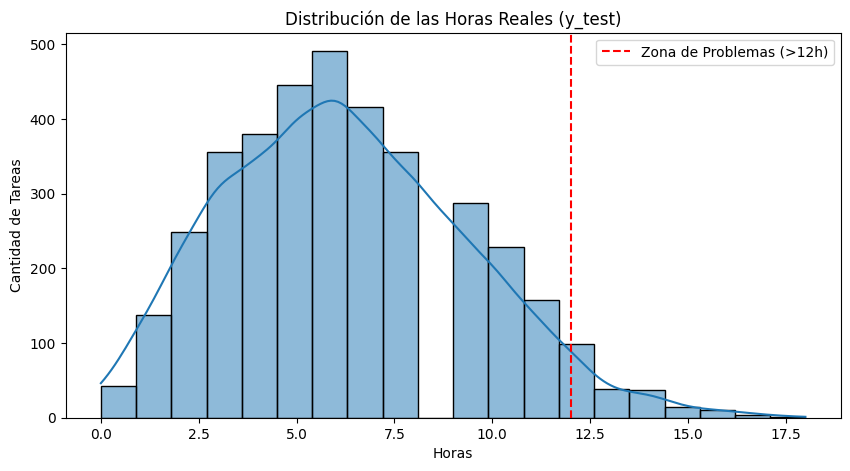

In [228]:
plt.figure(figsize=(10, 5))
# Histograma de la variable objetivo (y)
sns.histplot(y_test, kde=True, bins=20)
plt.title('Distribución de las Horas Reales (y_test)')
plt.xlabel('Horas')
plt.ylabel('Cantidad de Tareas')
plt.axvline(x=12, color='r', linestyle='--', label='Zona de Problemas (>12h)')
plt.legend()
plt.show()

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step


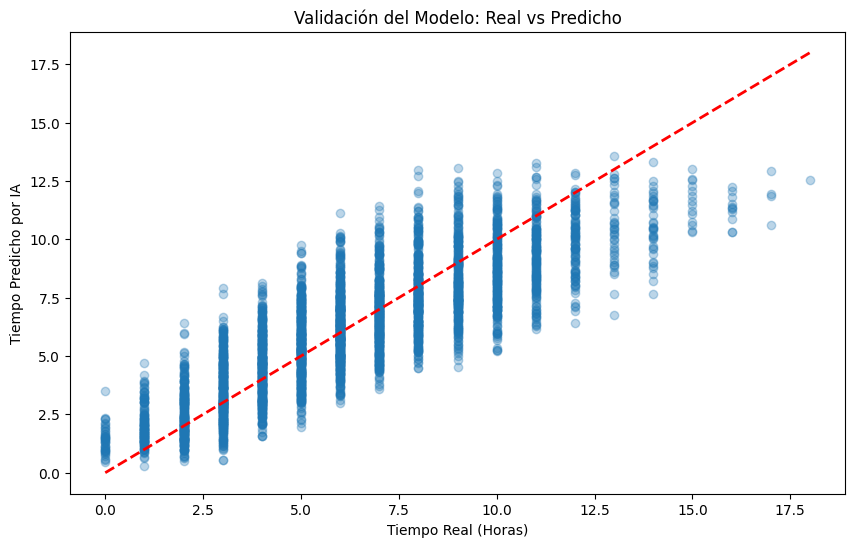

In [232]:
# Calculamos importancia permutando columnas en el set de Test
# NOTA: Al usar ColumnTransformer, las columnas cambian. 
# Para simplificar, analizamos correlación directa post-entrenamiento en el informe,
# o usamos este método aproximado sobre datos procesados.
# Aquí haremos algo más visual para tu informe: Gráfico de Predicción vs Realidad

y_pred = model.predict(X_test_proc).flatten()

plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Tiempo Real (Horas)')
plt.ylabel('Tiempo Predicho por IA')
plt.title('Validación del Modelo: Real vs Predicho')
plt.show()

In [236]:
y_train_log = np.log1p(y_train) # log1p es log(1+x) para evitar errores con 0
y_val_log = np.log1p(y_val)
y_test_log = np.log1p(y_test)

In [237]:
history = model.fit(
    X_train_proc, y_train_log,
    validation_data=(X_val_proc, y_val_log),
    batch_size=32,
    epochs=30, 
    verbose=0  
)

In [238]:
loss_mae = model.evaluate(X_test_proc, y_test_log, verbose=0)
print(f"\n--- RESULTADOS EXPERIMENTO 1 ---")
print(f"Error Absoluto Medio (MAE): {loss_mae[0]:.4f} horas")


--- RESULTADOS EXPERIMENTO 1 ---
Error Absoluto Medio (MAE): 0.2170 horas


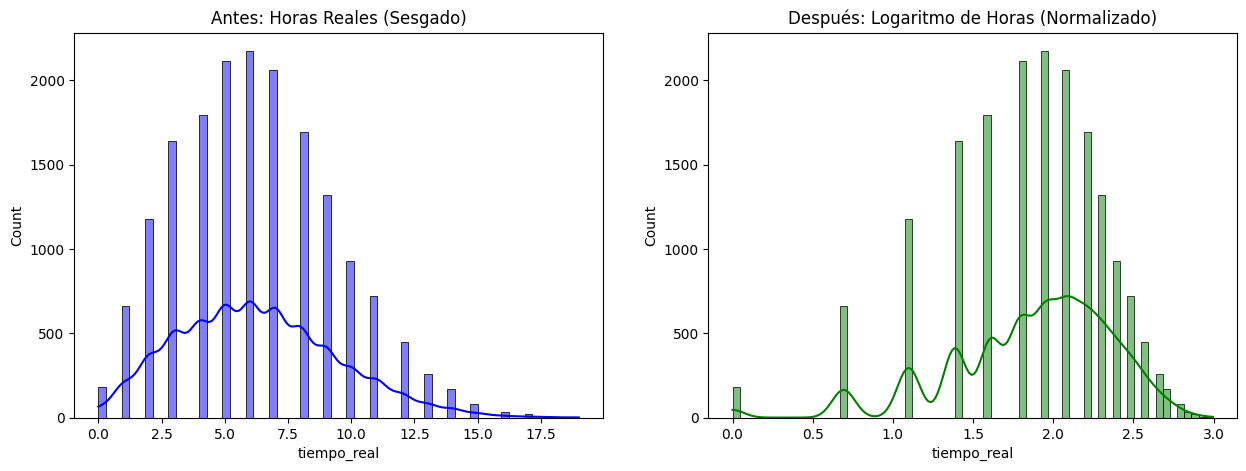

In [239]:
#1. Aplicamos la transformación
y_train_log = np.log1p(y_train)

# 2. Graficamos el Antes y el Después
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico Original (La rampa)
sns.histplot(y_train, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Antes: Horas Reales (Sesgado)')

# Gráfico Transformado (Debería ser una campana)
sns.histplot(y_train_log, kde=True, ax=axes[1], color='green')
axes[1].set_title('Después: Logaritmo de Horas (Normalizado)')

plt.show()

In [240]:
# 1. Predecir (el modelo te dará valores en escala logarítmica)
y_pred_log = model.predict(X_test_proc).flatten()

# 2. Invertir la transformación (Volver a horas reales)
# Usamos expm1 porque es la inversa de log1p
y_pred_real = np.expm1(y_pred_log)

# 3. Calcular el nuevo MAE real
from sklearn.metrics import mean_absolute_error
nuevo_mae = mean_absolute_error(y_test, y_pred_real)
print(f"Nuevo Error MAE en Horas Reales: {nuevo_mae:.4f}")

# 4. Ver si mejoró en los casos difíciles (Top errores)
import pandas as pd
resultados = pd.DataFrame({
    'Real': y_test,
    'Predicho_Log': y_pred_real # Ahora esto está en horas
})
resultados['Diferencia'] = abs(resultados['Real'] - resultados['Predicho_Log'])

print("\n--- ¿Mejoramos las tareas largas? (Top 5 errores actuales) ---")
print(resultados.sort_values(by='Diferencia', ascending=False).head(5))

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
Nuevo Error MAE en Horas Reales: 1.4231

--- ¿Mejoramos las tareas largas? (Top 5 errores actuales) ---
       Real  Predicho_Log  Diferencia
17742   8.0     14.789288    6.789288
22364  14.0      7.316635    6.683365
14071  18.0     11.516892    6.483108
13010   8.0     14.398430    6.398430
2085   12.0      5.628681    6.371319


Segundo modelo

In [165]:
model_2 = keras.Sequential([
    # Capa de entrada dinámica según las columnas procesadas
    keras.layers.Input(shape=(X_train_proc.shape[1],)),
    
    # Capas Ocultas (Arquitectura Base)
    keras.layers.Dense(64, activation='softmax'), # 64 neuronas
    keras.layers.Dense(32, activation='softmax'), # 32 neuronas
    
    # Capa de Salida (1 sola neurona lineal para regresión)
    keras.layers.Dense(1, activation='linear')
])

In [166]:
model_2.compile(
    optimizer='adam',
    loss='mae', 
    metrics=['mse']
)

In [167]:
# Entrenamos (Usamos más epochs porque la red es más grande y tarda más en converger)
history = model_2.fit(
    X_train_proc, y_train,
    validation_data=(X_val_proc, y_val),
    batch_size=32,
    epochs=30, 
    verbose=0  
)

In [168]:
loss_2 = model_2.evaluate(X_test_proc, y_test, verbose=0)
print(f"Error MAE Final (Exp 2): {loss_2[0]:.4f} horas")

Error MAE Final (Exp 2): 1.3135 horas


118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step


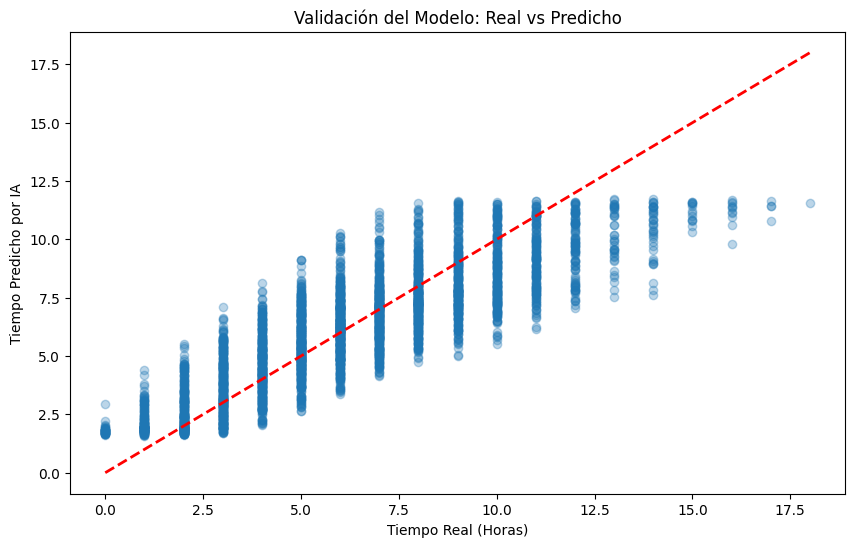

In [58]:
y_pred = model_2.predict(X_test_proc).flatten()

plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Tiempo Real (Horas)')
plt.ylabel('Tiempo Predicho por IA')
plt.title('Validación del Modelo: Real vs Predicho')
plt.show()

TERCER MODELO

In [178]:
model_3 = keras.Sequential([
     keras.layers.Input(shape=(X_train_proc.shape[1],)),
    
     keras.layers.Dense(256, activation='relu'),
     keras.layers.Dropout(0.3), # Apaga el 30% de las neuronas aleatoriamente (evita memoria)
    
     keras.layers.Dense(128, activation='relu'),
     keras.layers.Dropout(0.2), # Apaga el 20%
    
     keras.layers.Dense(64, activation='relu'),
    
     keras.layers.Dense(1, activation='linear')
])

In [183]:
# Configuramos un optimizador con Learning Rate personalizado
# Un valor más bajo (0.0005) ayuda a encontrar el mínimo global con más precisión
optimizer_custom = keras.optimizers.Adam(learning_rate=0.0005)

model_3.compile(
    optimizer=optimizer_custom,
    loss='mae',
    metrics=['mse']
)

In [184]:
# Agregamos EarlyStopping: Si el modelo deja de mejorar, para solo.
# Esto ahorra tiempo y es una técnica "profesional" muy valorada.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [185]:
history_3 = model_3.fit(
    X_train_proc, y_train,
    validation_data=(X_val_proc, y_val),
    batch_size=64,
    epochs=100, # Ponemos muchas, el EarlyStopping lo cortará cuando esté listo
    callbacks=[early_stop],
    verbose=0
)

In [54]:
loss_3 = model_3.evaluate(X_test_proc, y_test, verbose=0)
print(f"Error MAE Final (Exp 3): {loss_3[0]:.4f} horas")

Error MAE Final (Exp 3): 1.2958 horas


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step


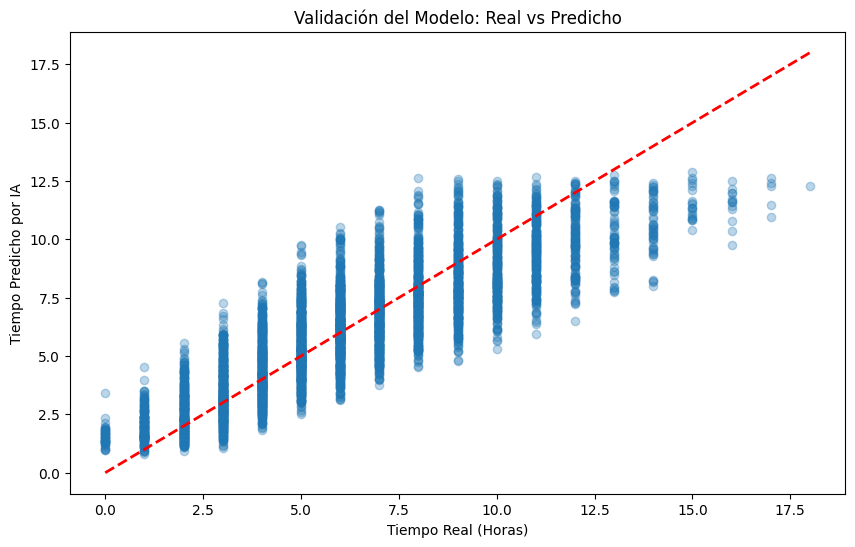

In [56]:
y_pred = model_3.predict(X_test_proc).flatten()

plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Tiempo Real (Horas)')
plt.ylabel('Tiempo Predicho por IA')
plt.title('Validación del Modelo: Real vs Predicho')
plt.show()